In [1]:
#Librarires and functions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import Video

from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.arena.tethered import Tethered
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.examples.cpg_controller import CPGNetwork
from flygym.mujoco.examples.obstacle_arena import ObstacleOdorArena

from typing import Union, Tuple


from gymnasium import spaces
from gymnasium.utils.env_checker import check_env

In [2]:
#Implementing a standard tripod gait
_tripod_phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
_tripod_coupling_weights = (_tripod_phase_biases > 0) * 10

In [3]:
#Implementing a windy arena with a laminar wind
from dm_control.mjcf.physics import Physics

class ObstacleTerrain(FlatTerrain):
    """ Classe implementing a flat terrain with obstacles.
    """
    def __init__(self, 
                 terrain: FlatTerrain,
                 obstacle_positions: np.ndarray = np.array([(8, -3), (8,-3), (8,-3)]),
                    obstacle_colors: Union[np.ndarray, Tuple] = (0, 0, 0, 1),
                    obstacle_width: float = 0.5,
                    obstacle_Length: float = 40,
                    obstacle_height: float = 4,
        ):
        super().__init__()
        self.terrain_arena = terrain
        self.obstacle_positions = obstacle_positions
        self.root_element = terrain.root_element
        self.friction = terrain.friction
        z_offset = terrain.get_spawn_position(np.zeros(3), np.zeros(3))[0][2]
        self.obstacle_width = obstacle_width
        self.obstacle_Length = obstacle_Length
        self.obstacle_height = obstacle_height
        self.obstacle_z_pos = z_offset + obstacle_height / 2
        obstacle_colors = np.array(obstacle_colors)
        if obstacle_colors.shape == (4,):
            obstacle_colors = np.array(
                [obstacle_colors for _ in range(obstacle_positions.shape[0])]
            )
        else:
            assert obstacle_colors.shape == (obstacle_positions.shape[0], 4)

        # Add obstacles
        self.obstacle_bodies = []
        obstacle_material = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        
        for i in range(obstacle_positions.shape[0]):
            obstacle_pos = [*obstacle_positions[i, :], self.obstacle_z_pos]
            obstacle_color = obstacle_colors[i]
            obstacle_body = self.root_element.worldbody.add(
                "body", name=f"obstacle_{i}", mocap=True, pos=obstacle_pos
            )
            self.obstacle_bodies.append(obstacle_body)
            obstacle_body.add(
                "geom",
                type="box",
                pos = np.array([0,0,0]),
                size= (obstacle_Length/2, obstacle_width/2, obstacle_height / 2),
                rgba=obstacle_color,
                material=obstacle_material,
            )


class WindArena(ObstacleTerrain):
    def __init__(
        self,
        #Change wind direction here
        wind_vector=[0, 4, 0],
        medium_density=0.01,
        medium_viscosity=0.01,
        **kwargs
    ):
        super().__init__(**kwargs)
        self._add_wind(wind_vector, medium_density, medium_viscosity)
        self.wind_vector = wind_vector


    def _add_wind(self, wind_vector, medium_density, medium_viscosity):
        self.root_element.option.__setattr__("density", medium_density)
        self.root_element.option.__setattr__("viscosity", medium_viscosity)
        self.root_element.option.__setattr__("wind", wind_vector)



In [4]:
from typing import Any, Dict, Tuple

class WindTurningNMF(NeuroMechFly):
    def __init__(
        self,
        preprogrammed_steps=None,
        intrinsic_freqs=np.ones(6) * 12,
        intrinsic_amps=np.ones(6) * 1,
        phase_biases=_tripod_phase_biases,
        coupling_weights=_tripod_coupling_weights,
        convergence_coefs=np.ones(6) * 20,
        init_phases=None,
        init_magnitudes=None,
        amplitude_range=(-0.5, 1.5),
        seed=0,
        **kwargs,
    ):
        # Initialize core NMF simulation
        super().__init__(**kwargs)

        if preprogrammed_steps is None:
            preprogrammed_steps = PreprogrammedSteps()
        self.preprogrammed_steps = preprogrammed_steps
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.phase_biases = phase_biases
        self.coupling_weights = coupling_weights
        self.convergence_coefs = convergence_coefs
        self.amplitude_range = amplitude_range

        # Define action and observation spaces
        self.action_space = spaces.Box(*amplitude_range, shape=(2,))

        # Initialize CPG network
        self.cpg_network = CPGNetwork(
            timestep=self.sim_params.timestep,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)
    
    def _set_joints_stiffness_and_damping(self):
        for joint in self.model.find_all("joint"):
            if joint.name in self.actuated_joints:
                joint.stiffness = self.sim_params.joint_stiffness
                joint.damping = self.sim_params.joint_damping
            #elif "Arista" in joint.name:
                #joint.stiffness = 0.002
                #joint.damping = 1e-5
            elif "LArista" in joint.name:
                joint.stiffness = 0.006
                joint.damping = 2e-4
            elif "RArista" in joint.name:
                joint.stiffness = 0.006
                joint.damping = 2e-4
            elif "Head" in joint.name:
                joint.stiffness = 1000.0
                joint.damping = 1000.0
            else:
                joint.stiffness = self.sim_params.non_actuated_joint_stiffness
                joint.damping = self.sim_params.non_actuated_joint_damping
            
    def _add_joint_sensors(self):
        self._arista_sensors = []
        self._debug_end_effectors = []

        for side in "LR":
            arista_sensor_joint = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista", joint=f"joint_{side}Arista"
            )
            arista_sensor_torque = self.model.sensor.add(
                "jointactuatorfrc", name=f"jointactuatorfrc_{side}Arista", joint=f"joint_{side}Arista"
            )
            self._arista_sensors.append(arista_sensor_torque)
            self._arista_sensors.append(arista_sensor_joint)            

        return super()._add_joint_sensors()
    
    def get_observation(self):
        obs = super().get_observation()
        arista_obs = self.physics.bind(self._arista_sensors).sensordata
        obs["arista_joint_pos"] = arista_obs.copy()
        
        return obs
    
    def _define_observation_space(self):
        _observation_space = {
            "joints": spaces.Box(
                low=-np.inf, high=np.inf, shape=(3, len(self.actuated_joints))
            ),
            "fly": spaces.Box(low=-np.inf, high=np.inf, shape=(4, 3)),
            "contact_forces": spaces.Box(
                low=-np.inf, high=np.inf, shape=(len(self.contact_sensor_placements), 3)
            ),
            # x, y, z positions of the end effectors (tarsus-5 segments)
            "end_effectors": spaces.Box(low=-np.inf, high=np.inf, shape=(6, 3)),
            "fly_orientation": spaces.Box(low=-np.inf, high=np.inf, shape=(3,)),
            "arista_joint_pos": spaces.Box(low=-np.inf, high=np.inf, shape=(4,))
        }
        if self.sim_params.enable_vision:
            _observation_space["vision"] = spaces.Box(
                low=0,
                high=255,
                shape=(2, self._mujoco_config["vision"]["num_ommatidia_per_eye"], 2),
            )
        if self.sim_params.enable_olfaction:
            _observation_space["odor_intensity"] = spaces.Box(
                low=0,
                high=np.inf,
                shape=(self.arena.odor_dimensions, len(self._antennae_sensors)),
            )
        return spaces.Dict(_observation_space)

    def reset(self, seed=None, init_phases=None, init_magnitudes=None, **kwargs):
        obs, info = super().reset(seed=seed)
        self.cpg_network.random_state = np.random.RandomState(seed)
        self.cpg_network.intrinsic_amps = self.intrinsic_amps
        self.cpg_network.intrinsic_freqs = self.intrinsic_freqs
        self.cpg_network.reset(init_phases, init_magnitudes)
        #Reset the obs by hand
        obs["arista_joint_pos"] = np.zeros((4,))
        return obs, info

    def step(self, action):
        """Step the simulation forward one timestep.

        Parameters
        ----------
        action : np.ndarray
            Array of shape (2,) containing descending signal encoding
            turning.
        """
        # update CPG parameters
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).flatten()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs

        self.cpg_network.step()

        joints_angles = []
        adhesion_onoff = []
        for i, leg in enumerate(self.preprogrammed_steps.legs):
            # get target angles from CPGs and apply correction
            my_joints_angles = self.preprogrammed_steps.get_joint_angles(
                leg,
                self.cpg_network.curr_phases[i],
                self.cpg_network.curr_magnitudes[i],
            )
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = self.preprogrammed_steps.get_adhesion_onoff(
                leg, self.cpg_network.curr_phases[i]
            )
            adhesion_onoff.append(my_adhesion_onoff)

        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        return super().step(action)

In [5]:
run_time = 5

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_top",
    render_playspeed=0.5,
    enable_adhesion=True
)

terrain = FlatTerrain()

wind_arena = WindArena(
    terrain=terrain,
)

nmf = WindTurningNMF(
    sim_params = sim_params,
    arena = wind_arena,
    #arena = wind_arena,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0,0,0.2),
    #when i change spawn orient camera angle change as well
)

(-0.5, 639.5, 479.5, -0.5)

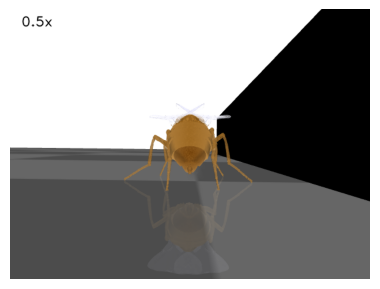

In [6]:
nmf.sim_params.render_camera = "Animat/camera_back" 

for i in range(500):
    obs, reward, terminated, truncated, info = nmf.step(np.zeros(2))
    nmf.render()

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(nmf._frames[-1])
ax.axis("off")

In [7]:
nmf.sim_params.render_camera = "Animat/camera_back" 
obs_list = []
magnitude_hist = []
end_effector_L = []
end_effector_R = []

AverageWindowL = np.array([])
AverageWindowR = np.array([])

target_num_steps = int(run_time / nmf.timestep)

obs, info = nmf.reset(seed=0)

for i in trange(target_num_steps) :
    curr_time = i * nmf.sim_params.timestep

    L = obs["arista_joint_pos"][1]
    R = obs["arista_joint_pos"][3]

    if((L-R)>0.005) :
        action=np.array([1, 0.2])
    else :
        action = np.array([1, 1])
    
    
    obs, reward, terminated, truncated, info = nmf.step(action)

    AverageWindowL=np.append(AverageWindowL,obs["arista_joint_pos"][1])
    AverageWindowR=np.append(AverageWindowR,obs["arista_joint_pos"][3])

    if(len(AverageWindowL)>=2000):
       AverageWindowL=np.delete(AverageWindowL,0)
       AverageWindowR=np.delete(AverageWindowR,0)

    obs["arista_joint_pos"][1]=np.mean(AverageWindowL)
    obs["arista_joint_pos"][3]=np.mean(AverageWindowR)


    obs_list.append(obs)    


    end_effector_L.append(nmf.physics.named.data.qpos[f"Animat/joint_LArista"].copy())
    end_effector_R.append(nmf.physics.named.data.qpos[f"Animat/joint_RArista"].copy())
    magnitude_hist.append(nmf.cpg_network.curr_magnitudes.copy())

    nmf.render()


nmf.save_video("obstacle_back.mp4", 0)


100%|██████████| 50000/50000 [09:15<00:00, 89.96it/s] 


In [8]:
nmf.sim_params.render_camera = "Animat/camera_top" 

obs_list = []
magnitude_hist = []
end_effector_L = []
end_effector_R = []

AverageWindowL = np.array([])
AverageWindowR = np.array([])

target_num_steps = int(run_time / nmf.timestep)

obs, info = nmf.reset(seed=0)

for i in trange(target_num_steps) :
    curr_time = i * nmf.sim_params.timestep #might be useless
    #if((L-R)>0.010):
    #  action=np.array([1, 0.2])
    #if((L-R)<-0.010):
    #  action=np.array([0.1, 1])

    L = obs["arista_joint_pos"][1]
    R = obs["arista_joint_pos"][3]

    if((L-R)>0.005) :
        action=np.array([1, 0.2])
    else :
        action = np.array([1, 1])
    
    
    obs, reward, terminated, truncated, info = nmf.step(action)

    AverageWindowL=np.append(AverageWindowL,obs["arista_joint_pos"][1])
    AverageWindowR=np.append(AverageWindowR,obs["arista_joint_pos"][3])

    if(len(AverageWindowL)>=2000):
       AverageWindowL=np.delete(AverageWindowL,0)
       AverageWindowR=np.delete(AverageWindowR,0)

    obs["arista_joint_pos"][1]=np.mean(AverageWindowL)
    obs["arista_joint_pos"][3]=np.mean(AverageWindowR)


    obs_list.append(obs)    


    end_effector_L.append(nmf.physics.named.data.qpos[f"Animat/joint_LArista"].copy())
    end_effector_R.append(nmf.physics.named.data.qpos[f"Animat/joint_RArista"].copy())
    magnitude_hist.append(nmf.cpg_network.curr_magnitudes.copy())

    nmf.render()


nmf.save_video("obstacle_top.mp4", 0)


100%|██████████| 50000/50000 [09:57<00:00, 83.64it/s] 


In [9]:
import cv2
cap = cv2.VideoCapture("obstacle_top.mp4")
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
fps = cap.get(cv2.CAP_PROP_FPS) 
normalised_arrow = wind_arena.wind_vector[0:2]/np.linalg.norm(wind_arena.wind_vector[0:2])
   
size = (frame_width, frame_height)
out = cv2.VideoWriter('obstaclewind2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

In [10]:
while(True): 
      
    # reading from frame 
    ret,frame = cap.read() 
    if ret: 

        cv2.arrowedLine(
            frame,
            (int(frame_width/2), int(frame_height/2)),
            # Need to invert sign of y coordinate as the zero is on top
            (int(frame_width/2+50*wind_arena.wind_vector[0]), int(frame_height/2-50*wind_arena.wind_vector[1])),
            color=(0, 0, 25),
            thickness=2,
            tipLength=0.1,
        )

        # save all frames as a video
        out.write(frame)
    else: 
        break

# Release all space and windows once done 
cap.release() 
out.release()
cv2.destroyAllWindows()

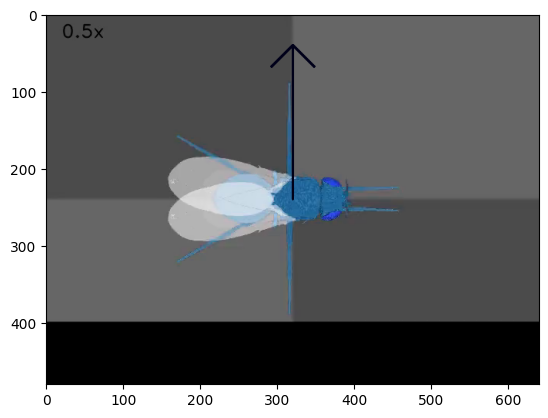

In [11]:
cap = cv2.VideoCapture("obstacle.mp4")
ret,frame = cap.read() 
cv2.arrowedLine(
            frame,
            (int(frame_width/2), int(frame_height/2)),
            # Need to invert sign of y coordinate as the zero is on top
            (int(frame_width/2+50*wind_arena.wind_vector[0]), int(frame_height/2-50*wind_arena.wind_vector[1])),
            color=(0, 0, 25),
            thickness=2,
            tipLength=0.2,
        )
plt.imshow(frame)

In [12]:
# Please have a look at the video from your file, as Jupyter notebook seems to have problem rendering it in the notebook
Video("./obstaclewind2.mp4")